# Tutorial 2: Integrating RNA and imaging modalities
In this tutorial, we demonstrate how to use SCIGMA to analyze a 10x Xenium Prime Ovarian Cancer dataset. This tutorial can be run in about 2 hours on a GPU-enabled computer.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from SCIGMA import *
from data import load_data, preprocessing
import numpy as np
import matplotlib.pyplot as plt
from utils import clustering
import scanpy as sc
import pandas as pd
import tifffile
import anndata as ad
from img_feat import ImageFeature

## Load Data
To run this tutorial, ensure that the data is downloaded from: https://www.10xgenomics.com/datasets/xenium-prime-fresh-frozen-human-ovary 

In [3]:
from scipy import sparse

path = "/oscar/data/yma16/Spatial/raw/10x_XeniumPrime/Xenium_Prime_Human_Ovary_FF_outs/"
adata = sc.read_10x_h5(path+'/cell_feature_matrix.h5')
adata.var_names_make_unique()
cell_info = pd.read_csv(path+'/cells.csv.gz', sep=",")
adata.obsm['spatial'] = cell_info[['y_centroid','x_centroid']].to_numpy()
adata.X = sparse.csr_matrix(adata.X)

Convert spatial coordinates to pixel space

In [ ]:
adata.obsm['spatial'] = adata.obsm['spatial']/0.2125

Read in image

In [ ]:
print("reading image")
fullres_multich_img = tifffile.imread(path+'/morphology_focus/morphology_focus_0000.ome.tif', is_ome=False, level=0)

reading image


Store image

In [ ]:
im = fullres_multich_img.astype(np.float32)
del fullres_multich_img
im = (im-np.min(im))/(np.max(im)-np.min(im))
adata.uns['image'] = im
adata.write_h5ad("scratch/10xXeniumPrime_Ovary/adata_with_images.h5ad")
print(type(im))
print(im.shape)
del im

<class 'numpy.ndarray'>
(101928, 54013)


Use pretrained model to extract features

In [3]:
adata = ad.read_h5ad("scratch/10xXeniumPrime_Ovary/adata_with_images.h5ad")
adata = ImageFeature(adata, pca_components=30).extract_image_feat()

single-channel image


Extract image feature: 100%|██████████ [ time left: 00:00 ]     


In [4]:
img_adata = ad.AnnData(adata.obsm['image_feat_pca'].copy())
del adata.obsm['image_feat_pca']
img_adata.obsm['spatial'] = adata.obsm['spatial']
img_adata.uns['img_feat'] = adata.obsm["image_feat"].copy()
del adata.obsm["image_feat"]
img_adata.obs_names = adata.obs_names

Save RNA and image AnnData objects

In [5]:
adata.write(f'/oscar/data/yma16/Project/SCIGMA/results/10xXeniumPrime/Human_Ovary/preprocessed/rna_raw_adata.h5ad')
img_adata.write(f'/oscar/data/yma16/Project/SCIGMA/results/10xXeniumPrime/Human_Ovary/preprocessed/image_raw_adata.h5ad')

Preprocess AnnDatas

In [ ]:
adata = ad.read_h5ad(f'/oscar/data/yma16/Project/SCIGMA/results/10xXeniumPrime/Human_Ovary/preprocessed/rna_raw_adata.h5ad')
img_adata = ad.read_h5ad(f'/oscar/data/yma16/Project/SCIGMA/results/10xXeniumPrime/Human_Ovary/preprocessed/image_raw_adata.h5ad')
data_dict = preprocessing(adata, img_adata, datatype='XeniumPrime', n_neighbors=6, feat_neighbors=6)

Preprocessing anndatas


Save preprocessed AnnDatas

In [ ]:
data_dict['adata_omics1'].write(f'/oscar/data/yma16/Project/SCIGMA/results/10xXeniumPrime/Human_Ovary/preprocessed/rna_adata.h5ad')
data_dict['adata_omics2'].write(f'/oscar/data/yma16/Project/SCIGMA/results/10xXeniumPrime/Human_Ovary/preprocessed/pretrained_image_adata.h5ad')

## Model Training

In [ ]:
# read preprocessed
data_dict = {}
data_dict['adata_omics1'] = ad.read_h5ad('/oscar/data/yma16/Project/SCIGMA/results/10xXeniumPrime/Human_Ovary/preprocessed/rna_adata_corrected.h5ad')
data_dict['adata_omics2'] = ad.read_h5ad('/oscar/data/yma16/Project/SCIGMA/results/10xXeniumPrime/Human_Ovary/preprocessed/pretrained_image_adata_corrected.h5ad')

In [4]:
model=None
gc.collect()

49

In [5]:
seed = 1000
model = SCIGMA(data_dict, seed_num=seed, device=torch.device('cuda:0'), dim_output=24, recon_weight1 = 1, recon_weight2 = 1, contrastive_weight1=1e-1, contrastive_weight2=1e-1, clr_weight=0.2, batch_size = 8000, downweight=0, learning_rate=1e-3, weight_decay=1e-2,connectivities=None)

Num samples pruned: 0
Creating adjacency matrices
Model ready for training!


In [ ]:
output = model.train(600)

In [11]:
adata_combined = data_dict['adata_omics1'].copy()
adata_combined.obsm['emb_latent_omics1'] = output['emb_latent_omics1']
adata_combined.obsm['emb_latent_omics2'] = output['emb_latent_omics2']
adata_combined.obsm['emb_combined'] = output['emb_latent_combined']
adata_combined.obs['tau'] = output['tau']
adata_combined.obs['invtau'] = output['invtau']

In [ ]:
# mclust clustering
tool = 'mclust' # mclust, leiden, and louvain

# clustering
if tool == 'mclust':
    clustering(adata_combined, key='emb_combined', add_key='SCIGMA', n_clusters=20, method=tool, use_pca=False)
elif tool in ['leiden', 'louvain']:
    clustering(adata_combined, key='emb_combined', add_key='SCIGMA', n_clusters=20, method=tool, start=0.1, end=2.0, increment=0.01)

In [ ]:
# visualization
fig, ax_list = plt.subplots(1, 1, figsize=(12, 12))
sc.pl.embedding(adata_combined, basis='spatial', color='SCIGMA', ax=ax_list, title='SCIGMA', s=5, show=False)
plt.gca()
plt.show()

/users/schang59/anaconda/glue/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


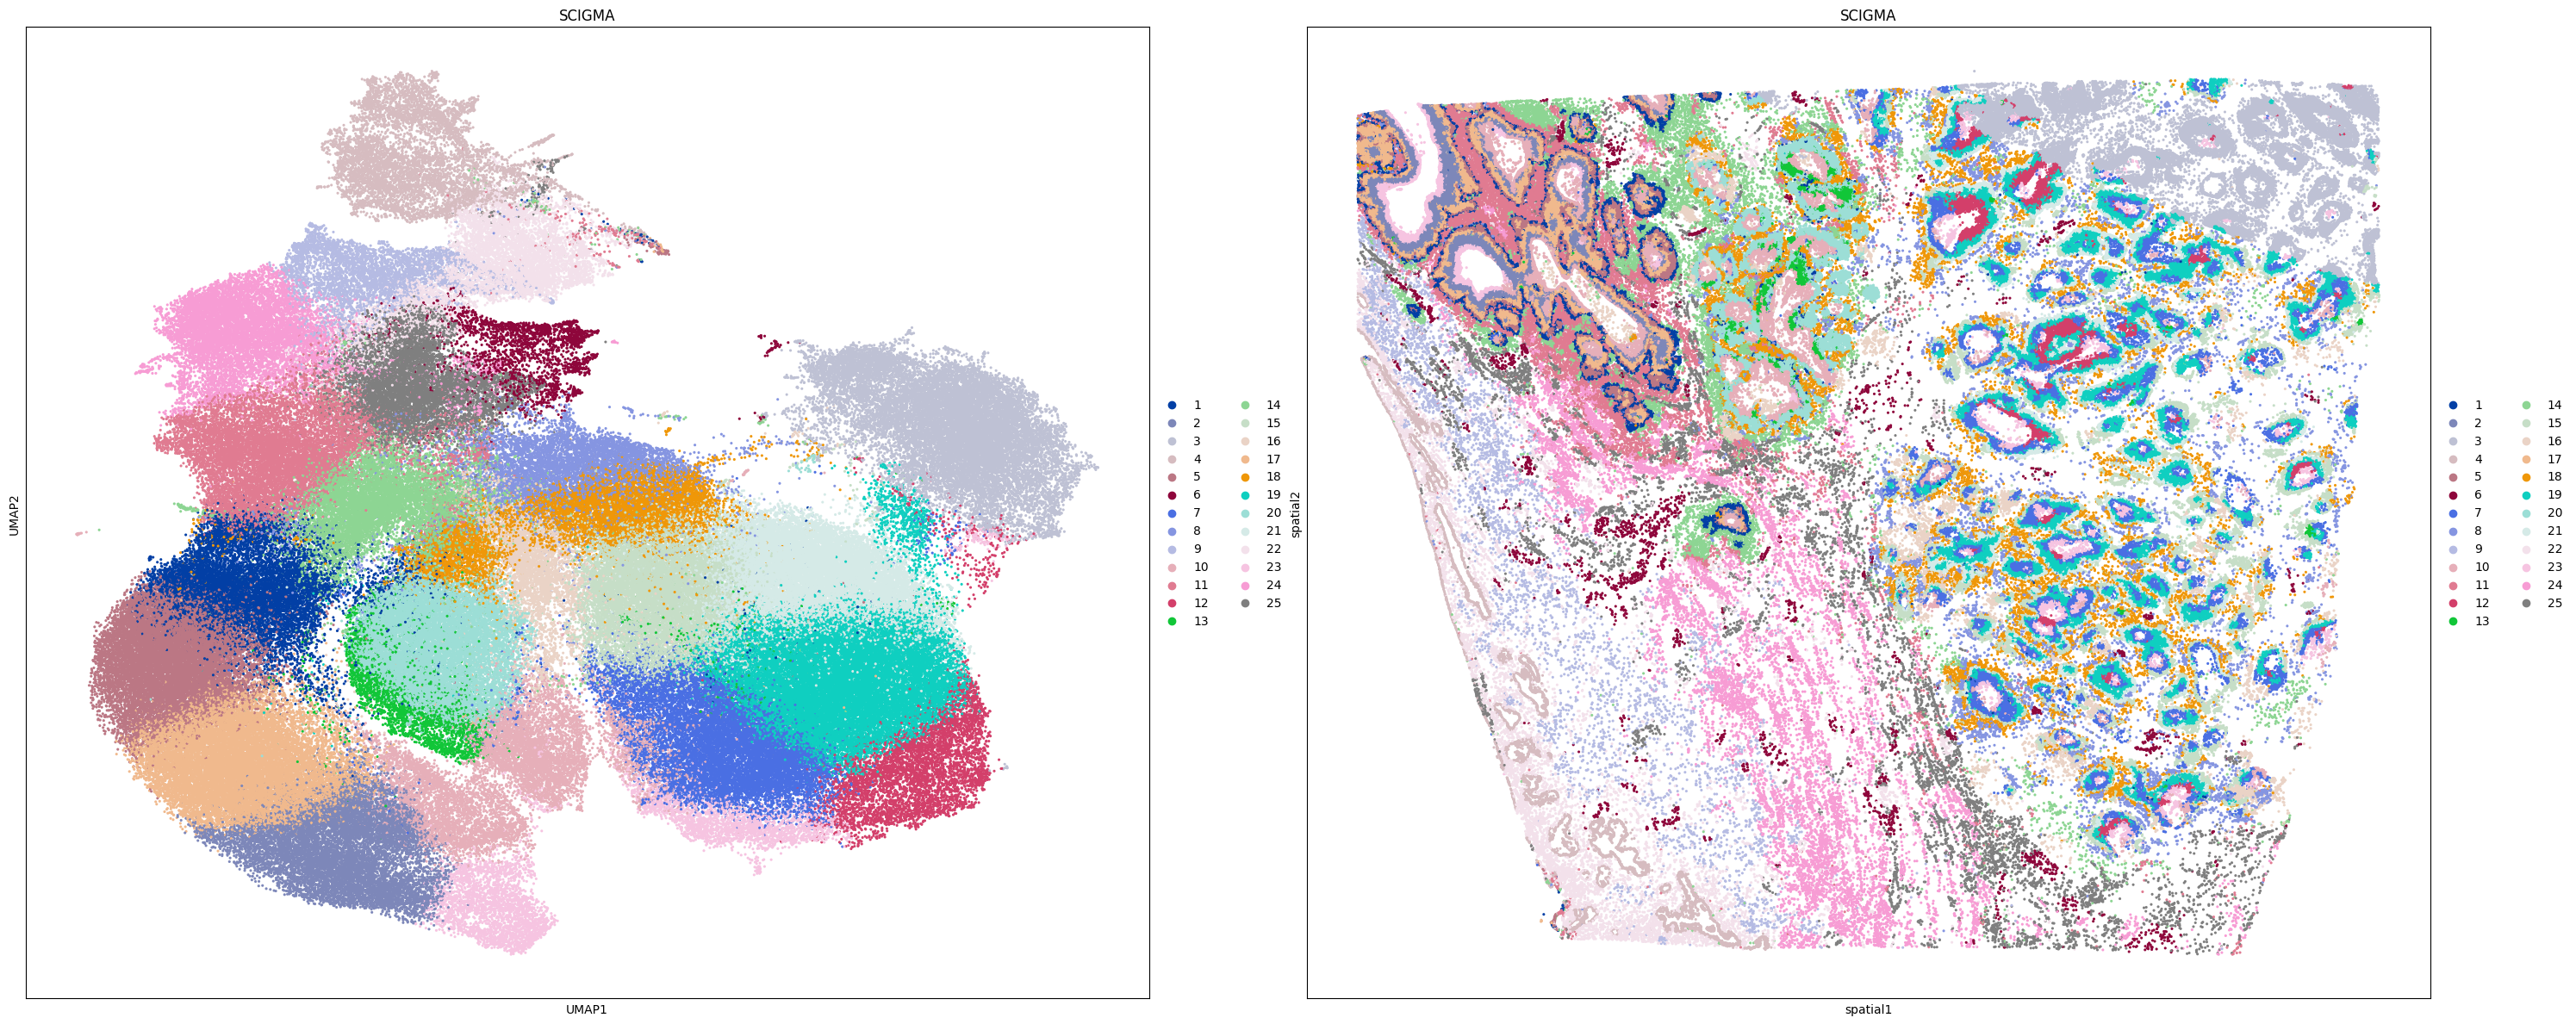

In [12]:
# visualization
fig, ax_list = plt.subplots(1, 2, figsize=(30, 12))
sc.pp.neighbors(adata_combined, use_rep='emb_combined', n_neighbors=10)
sc.tl.umap(adata_combined)

sc.pl.umap(adata_combined, color='SCIGMA', ax=ax_list[0], title='SCIGMA', s=20, show=False)
sc.pl.embedding(adata_combined, basis='spatial', color='SCIGMA', ax=ax_list[1], title='SCIGMA', s=20, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

# fig.savefig(f'/oscar/data/yma16/Project/SCIGMA/results/10xXeniumPrime/Human_Ovary/clustering/cluster_{25}')

In [ ]:
# uncertainty visualization
sc.pl.embedding(adata_combined, 
                basis='spatial', 
                color=['invtau'], 
                title=['Uncertainty'], s=10, show=False)
plt.gca().invert_xaxis()
plt.show()